# Goal: write and test DMD algorithm

In [1]:
include("foamLia/foamLia.jl")
using foamLia

baseCase = OpenFoam("/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase");
initCase(baseCase,"foamLia/test/juliabase/");
faces,cells = readMesh(baseCase);
points,indices = reshapeMesh(baseCase);

# let's go get the foward four points of each cell
# only get the yz coordinates
cellPoints = zeros(size(baseCase.fullMesh["cellFaces"])[2],4,3)
for cellID in 1:size(baseCase.fullMesh["cellFaces"])[2]
    faces = baseCase.fullMesh["cellFaces"][:,cellID]
    # println(faces)
    pointList = Int[]
    for faceID in 1:6
        face = faces[faceID]
        pointIDs = baseCase.fullMesh["faces"][:,face]
        # println(pointIDs)
        for pointID in 1:4
            point = pointIDs[pointID]
            if point ∉ pointList
                push!(pointList,point)
            end
        end
    end
    # println(pointList)
    # print(size(pointList))
    j = 0
    for (i,point) in enumerate(pointList)
        # println(i)
        # println(point)
        # println(baseCase.fullMesh["points"][:,point])
        pointXYZ = baseCase.fullMesh["points"][:,point]
        if pointXYZ[1] > 0
            j += 1
            cellPoints[cellID,j,:] = pointXYZ
        end
    end
end

times = 100:10:1000
println(size(times))
D = zeros(40000,size(times)[1])
for time=1:size(times)[1]
    t = times[time]
    T = readVar(baseCase,stringG(t),"T")
    D[:,time] = squeeze(T,1)
end

 in OrderedDict at deprecated.jl:26
 in create_defaultControlDict at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:83
 in OpenFoam at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:450
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /Users/andyreagan/.julia/v0.3/IJulia/src/execute_request.jl:157
 in eventloop at /Users/andyreagan/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in OrderedDict at deprecated.jl:26
 in create_defaultFvSchemes at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:106
 in OpenFoam at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:450
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /Users/andyreagan/.julia/v0.3/IJulia/src/execute_request.jl:157
 in eventloop at /Users/andyreagan/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in OrderedDict at deprecated.jl:26
 in create_defaultFvSchemes at /Users/a

/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/system exists
/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/constant/polyMesh exists
/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0 exists
copying over base case
copying foamLia/test/juliabase//Allrun to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/Allrun
copying foamLia/test/juliabase//0/alphat to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/alphat
copying foamLia/test/juliabase//0/p to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/p
copying foamLia/test/juliabase//0/p_rgh to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/p_rgh
copying foamLia/test/juliabase//0/T to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/T
copying foamLia/test/juliabase//0/U to /Users/andyreagan/work/2014/2014-11foamLab-julia/fo

In [15]:
times = 100:10:1000
println(size(times))
D = zeros(40000,size(times)[1])
for time=1:size(times)[1]
    t = times[time]
    T = readVar(baseCase,stringG(t),"T")
    D[:,time] = squeeze(T,1)
end

(91,)


In [90]:
# all of the function that are necessary for plotting
using PyPlot
using PyCall
@pyimport matplotlib as mpl
patches = mpl.pymember("patches")

RdYlBu = readcsv("/Users/andyreagan/work/2014/2014-11foamLab-julia/RdYlBu.csv");
function cmapper(cmap,val)
    squeeze(cmap[min(max(ceil(val*255),1),255),:],1)
end

lookup_table = zeros(40000,4)
lookup_table[1:19999,:] = repmat([1,2,4,3]',19999,1)
# bottom right
lookup_table[20000:30000,:] = repmat([1,2,3,4]',10001,1)
# flip every 40th
lookup_table[20000:40:29999,:] = repmat([1,2,4,3]',250,1)
lookup_table[30001:40000,:] = repmat([1,2,4,3]',10000,1)
lookup_table[40,:] = [1,2,3,4]'
lookup_table[39961:40000,:] = repmat([1,2,3,4]',40,1)
lookup_table[29961:29999,:] = repmat([1,2,4,3]',39,1)
function cell_point_order(cellID)
    # a lookup for how to reorder the point
    return squeeze(lookup_table[cellID,:],1)
end

function plot_loop_whole(T)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:].^3,closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    # PyPlot.matplotlib[:pyplot][:savefig]("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode01.pdf")
end

plot_loop_whole (generic function with 1 method)

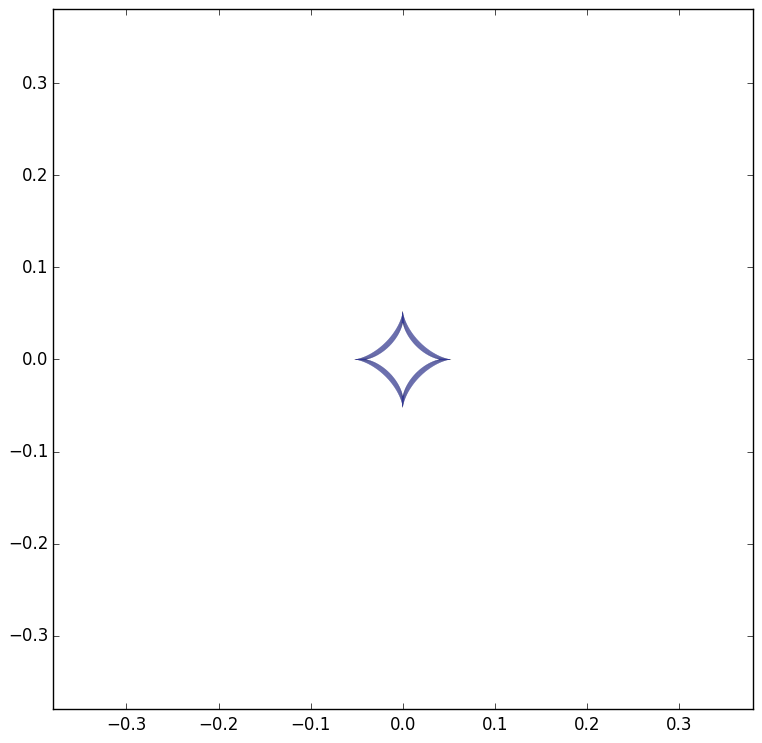

(-0.38,0.38)

In [3]:
function plot_loop_whole_save(T,fname)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    PyPlot.matplotlib[:pyplot][:savefig](fname)
end

plot_loop_whole_save (generic function with 1 method)

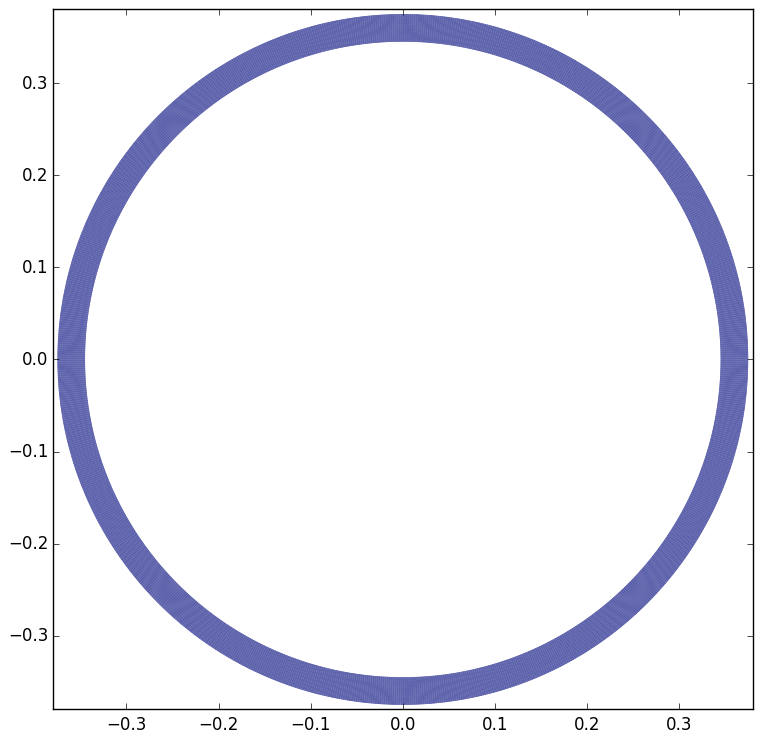

In [4]:
plot_loop_whole_save(D[:,1],"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode01.png")

In [6]:
Q,R = qr(D[:,1:end-1])

(
40000x90 Array{Float64,2}:
 -0.00522388  -0.00860451   -0.00436445   …  -0.0144299   -0.0116864  
 -0.00516347  -0.0119624    -0.00257669      -0.0201213   -0.0175683  
 -0.00509085  -0.020291     -0.000779277     -0.0211708   -0.010253   
 -0.00503053  -0.0285732     0.000154136     -0.0207372   -0.000241965
 -0.00501196  -0.0295912     0.000807484     -0.0194647    0.00675677 
 -0.00501204  -0.0278574     0.00109679   …  -0.0176392    0.0113473  
 -0.00501458  -0.0258237     0.00047534      -0.0157301    0.0143504  
 -0.00501704  -0.0230048    -0.00139938      -0.0141236    0.0162498  
 -0.00501927  -0.0192525    -0.00400097      -0.0128066    0.0172597  
 -0.00502126  -0.0149806    -0.00661728      -0.0112411    0.0176038  
 -0.00502284  -0.0105796    -0.00906684   …  -0.00929713   0.017655   
 -0.00502378  -0.00620151   -0.0114498       -0.00696661   0.0176125  
 -0.00502422  -0.00185756   -0.0138581       -0.00421775   0.0175616  
  ⋮                                       ⋱     

In [7]:
S = inv(R)*Q'*D[:,2:end]

90x90 Array{Float64,2}:
 -7.77156e-16   1.55431e-15  -1.69864e-14  …  -8.88178e-16   0.0127616 
  1.0           6.88338e-15   8.88178e-15     -1.44329e-14   0.0351168 
 -1.26774e-14   1.0          -9.6867e-15       1.1123e-14    0.0208955 
 -6.93889e-16   2.88658e-15   1.0              1.76525e-14  -0.0539764 
  1.34753e-14   1.14492e-14   1.27537e-14      1.40166e-15  -0.118358  
 -9.4369e-16   -1.45439e-14  -2.9976e-15   …   1.09357e-14  -0.0400474 
 -3.4972e-15   -2.22045e-15  -4.88498e-15      6.10623e-16   0.032848  
 -2.1802e-14   -6.4948e-15   -1.92069e-14     -1.23512e-14  -0.0253284 
  1.38778e-16  -2.22045e-15   5.68989e-15      1.34892e-14  -0.00333816
  6.18949e-15   1.17129e-14   5.46785e-15      1.113e-14    -0.0301165 
 -3.04756e-14  -1.94289e-14  -7.60503e-15  …   1.16573e-15   0.0743615 
  4.20497e-15  -1.15186e-15   5.61357e-15     -9.01362e-15   0.133929  
 -1.68754e-14   9.67282e-15  -1.72917e-14     -1.36419e-14   0.0872834 
  ⋮                                     

In [16]:
X,L = eig(S)

(Complex{Float64}[-0.973328+0.135192im,-0.973328-0.135192im,-0.968041+0.0490131im,-0.968041-0.0490131im,-0.955897+0.227252im,-0.955897-0.227252im,-0.88491+0.0im,-0.911905+0.295756im,-0.911905-0.295756im,-0.889598+0.340805im  …  0.940328+0.176556im,0.940328-0.176556im,0.904974+0.0im,-0.622489+0.118697im,-0.622489-0.118697im,0.576531+0.675349im,0.576531-0.675349im,0.696448+0.0im,-0.342352+0.503434im,-0.342352-0.503434im],
90x90 Array{Complex{Float64},2}:
  0.00177233+0.00165443im   …  -0.00755053+0.0111032im 
   0.0033222+0.00263684im       -0.0288839+0.0100422im 
 -7.75089e-5-0.000414033im     0.000675851-0.0303269im 
 -0.00747606-0.00656935im        0.0725026-0.0180323im 
 -0.00982163-0.00767566im        0.0275524+0.0121557im 
   0.0032634+0.00392001im   …   -0.0182648-0.00864772im
  0.00182136-0.000149647im      0.00918124+0.0117586im 
  -0.0053744-0.00338774im      -0.00946553-0.0204272im 
  0.00447927+0.00373436im        0.0384631+0.0031068im 
 -0.00817466-0.0082955im        -0.0219

In [17]:
X_mapped = log(X)/10

90-element Array{Complex{Float64},1}:
 -0.00174797+0.300358im 
 -0.00174797-0.300358im 
 -0.00312006+0.3091im   
 -0.00312006-0.3091im   
 -0.00176154+0.290819im 
 -0.00176154-0.290819im 
  -0.0122269+0.314159im 
 -0.00422113+0.282797im 
 -0.00422113-0.282797im 
  -0.0048513+0.277574im 
  -0.0048513-0.277574im 
 -0.00154783+0.267186im 
 -0.00154783-0.267186im 
            ⋮           
 -0.00132076+0.0100057im
 -0.00132076-0.0100057im
 -0.00442031+0.0185599im
 -0.00442031-0.0185599im
 -0.00998486+0.0im      
  -0.0456172+0.295317im 
  -0.0456172-0.295317im 
  -0.0118821+0.086417im 
  -0.0118821-0.086417im 
  -0.0361762+0.0im      
  -0.0496247+0.2168im   
  -0.0496247-0.2168im   

In [20]:
mode = 1
println(size(D))
println(size(L))
DM1 = D[:,1:end-1]*L[:,mode]

(40000,91)
(90,90)


40000-element Array{Complex{Float64},1}:
 -0.139544-0.147315im
  -0.95001+0.516993im
  -1.19081+0.662899im
  -1.11393+0.518936im
 -0.949885+0.223964im
 -0.799771-0.119448im
 -0.667556-0.45214im 
 -0.574285-0.740144im
 -0.535184-0.964858im
 -0.539509-1.12521im 
 -0.534759-1.14188im 
 -0.501414-1.01341im 
 -0.454556-0.81648im 
          ⋮          
  0.988727-0.219637im
  0.971927-0.245646im
  0.942356-0.284257im
  0.894541-0.332571im
  0.817742-0.353615im
   0.69511-0.310776im
  0.535563-0.264021im
  0.438607-0.354671im
  0.550798-0.547291im
   0.56631-0.696834im
 0.0533928-0.818241im
  -0.73237-0.83282im 

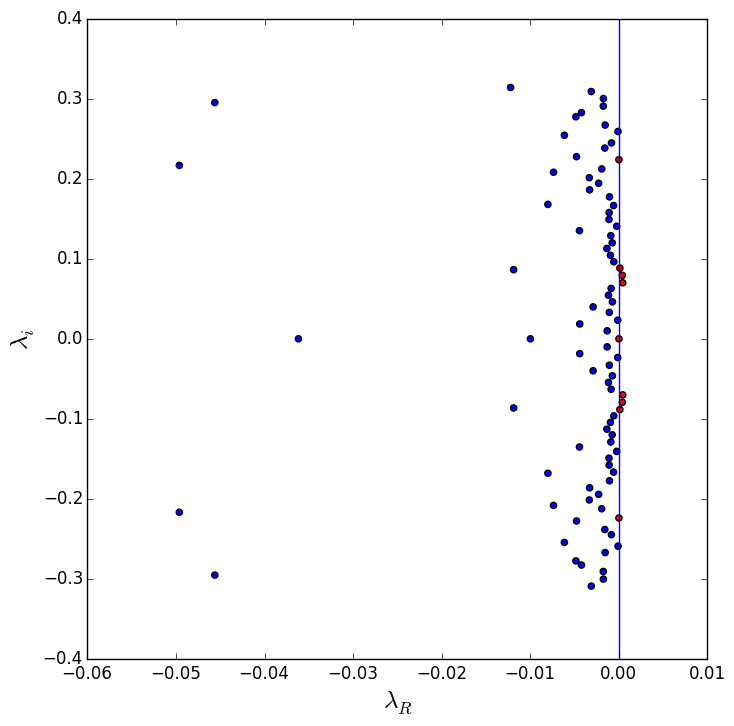

In [66]:
figure(figsize=(8,8))
scatter(real(X_mapped),imag(X_mapped),c=colors)
plot([0.0,0.0],[-1.0,1.0])
ylabel("\$\\lambda_i\$",size=18)
xlabel("\$\\lambda_R\$",size=18)
ylim([-.4,.4])
savefig("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-eigenvalues-mapped.png")

In [40]:
cos(linspace(0,2*pi))

100-element Array{Float64,1}:
 1.0     
 0.997987
 0.991955
 0.981929
 0.967949
 0.950071
 0.928368
 0.902927
 0.873849
 0.841254
 0.80527 
 0.766044
 0.723734
 ⋮       
 0.766044
 0.80527 
 0.841254
 0.873849
 0.902927
 0.928368
 0.950071
 0.967949
 0.981929
 0.991955
 0.997987
 1.0     

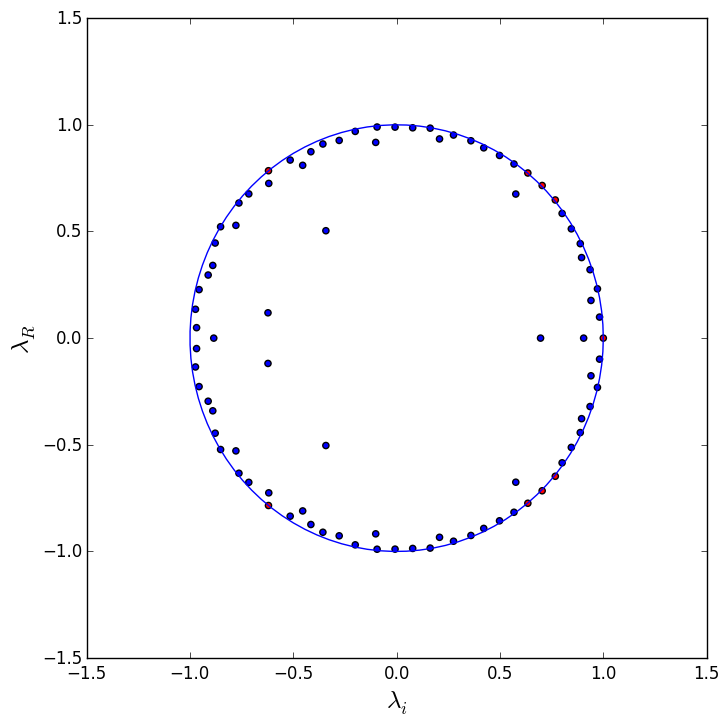

In [63]:
figure(figsize=(8,8))
colors = Array(String,length(X))
for i=1:length(X)
    if abs(X[i]) > 1
        colors[i] = "r"
    else
        colors[i] = "b"
    end
end
scatter(real(X),imag(X),c=colors)
# plot the unit circle
# modes inside are decaying
# modes outside are growing
plot(cos(linspace(0,2*pi)),sin(linspace(0,2*pi)))
xlabel("\$\\lambda_i\$",size=18)
ylabel("\$\\lambda_R\$",size=18)
savefig("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-eigenvalues-002.png")

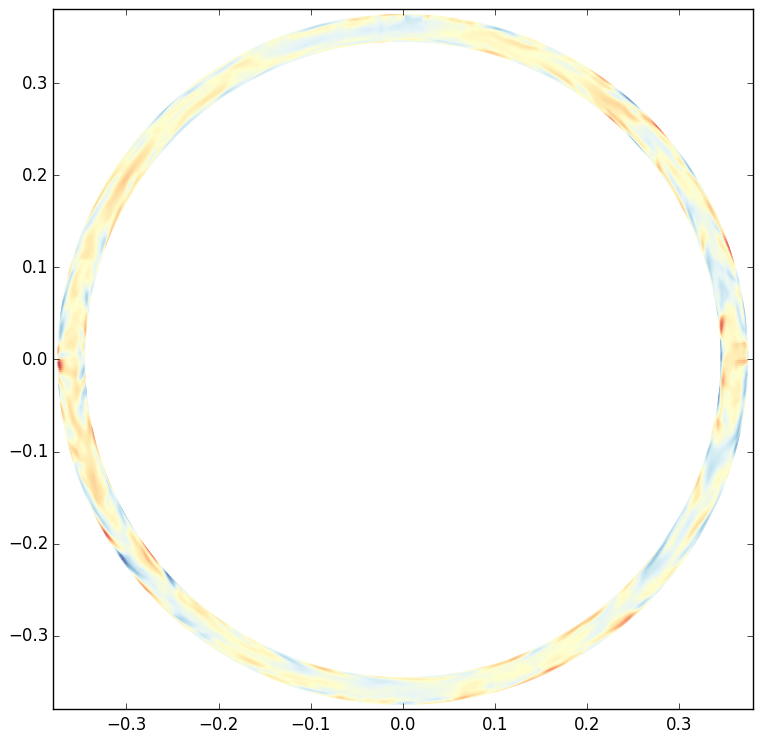

In [26]:
mode = 1
DM1 = D[:,1:end-1]*L[:,mode]
DM1real = real(DM1)
plot_loop_whole_save((DM1real-minimum(DM1real))/(maximum(DM1real)-minimum(DM1real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")

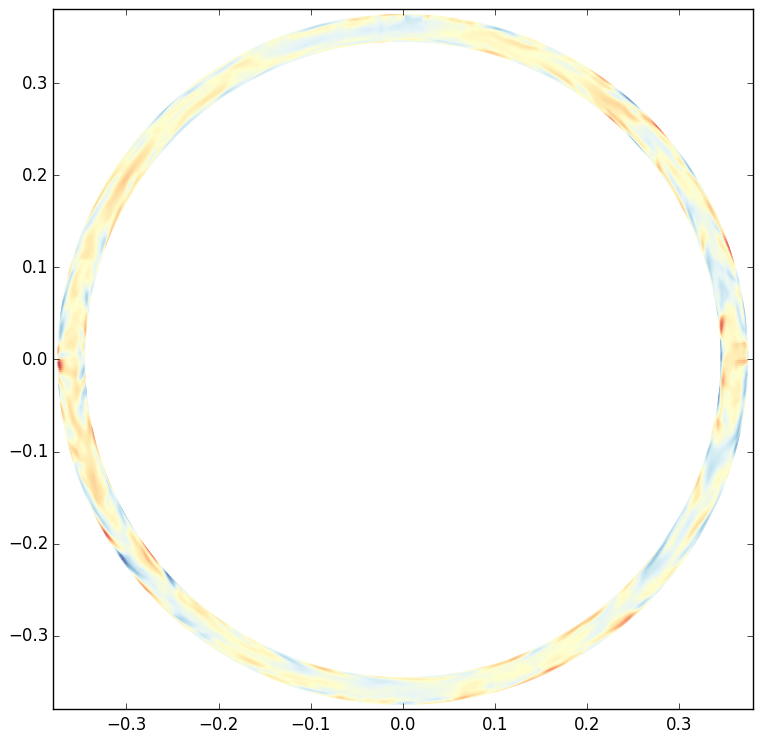

In [27]:
mode = 2
DM2 = D[:,1:end-1]*L[:,mode]
DM2real = real(DM2)
plot_loop_whole_save((DM2real-minimum(DM2real))/(maximum(DM2real)-minimum(DM2real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")

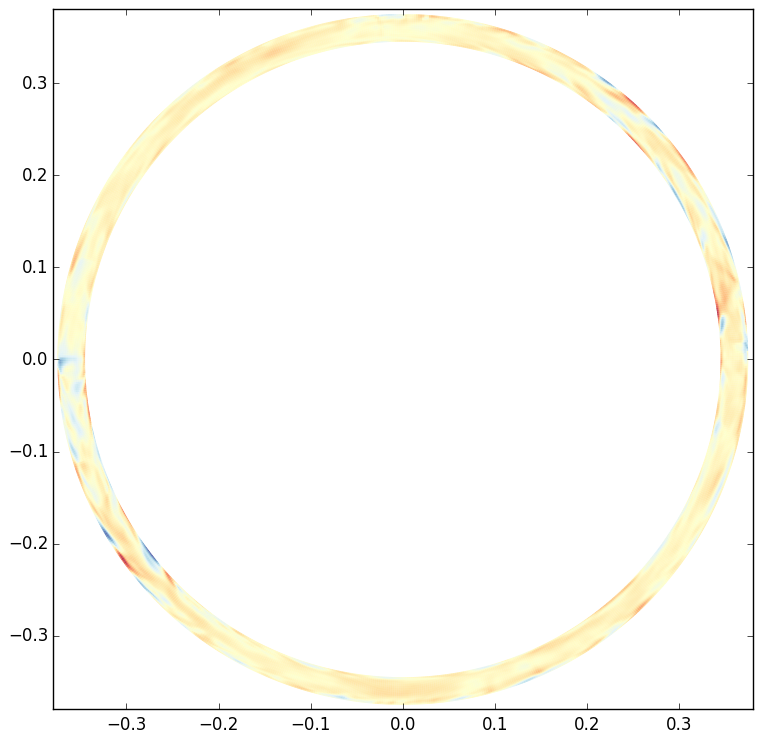

In [28]:
mode = 3
DM2 = D[:,1:end-1]*L[:,mode]
DM2real = real(DM2)
plot_loop_whole_save((DM2real-minimum(DM2real))/(maximum(DM2real)-minimum(DM2real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")

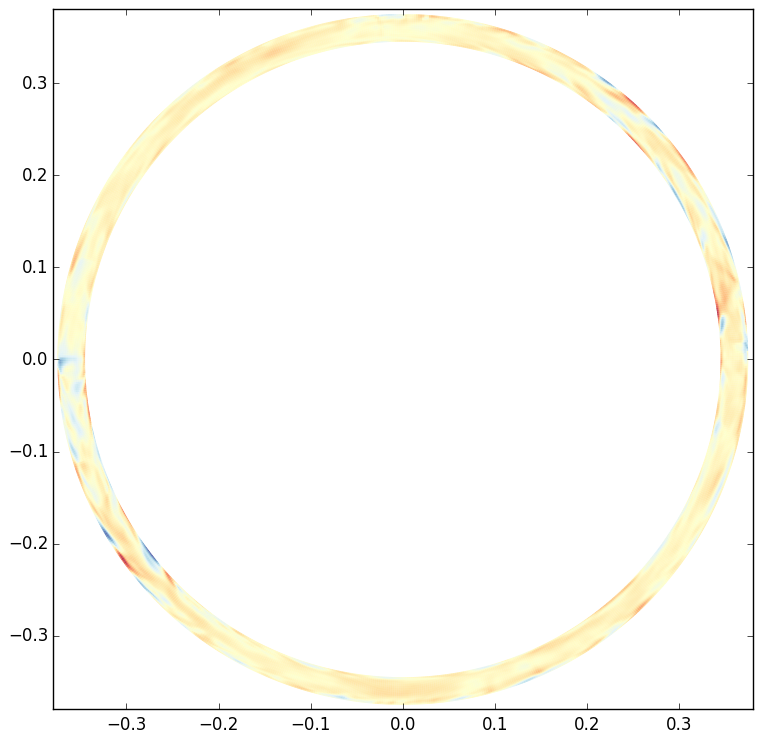

In [29]:
mode = 4
DM2 = D[:,1:end-1]*L[:,mode]
DM2real = real(DM2)
plot_loop_whole_save((DM2real-minimum(DM2real))/(maximum(DM2real)-minimum(DM2real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")

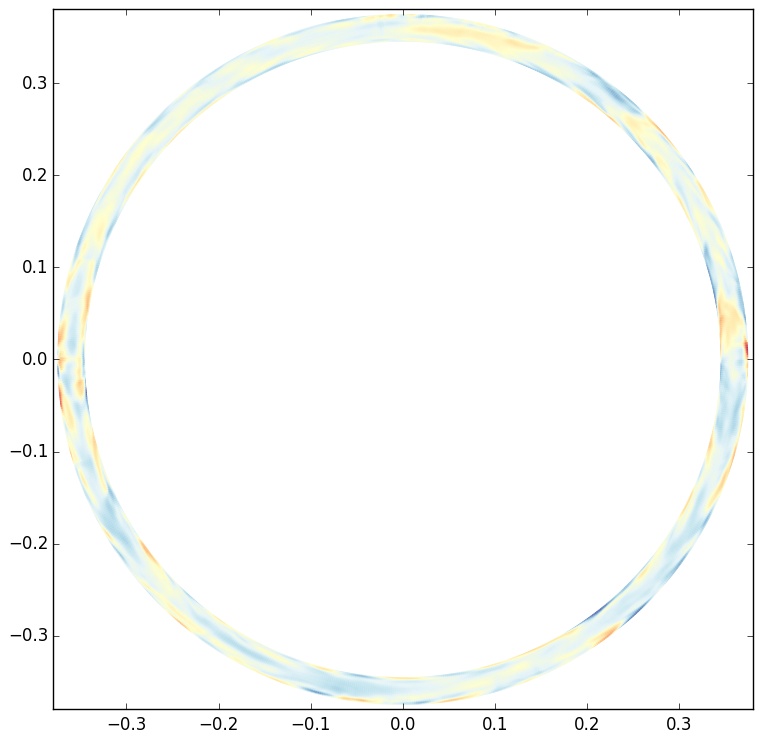

In [30]:
mode = 5
DM2 = D[:,1:end-1]*L[:,mode]
DM2real = real(DM2)
plot_loop_whole_save((DM2real-minimum(DM2real))/(maximum(DM2real)-minimum(DM2real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")

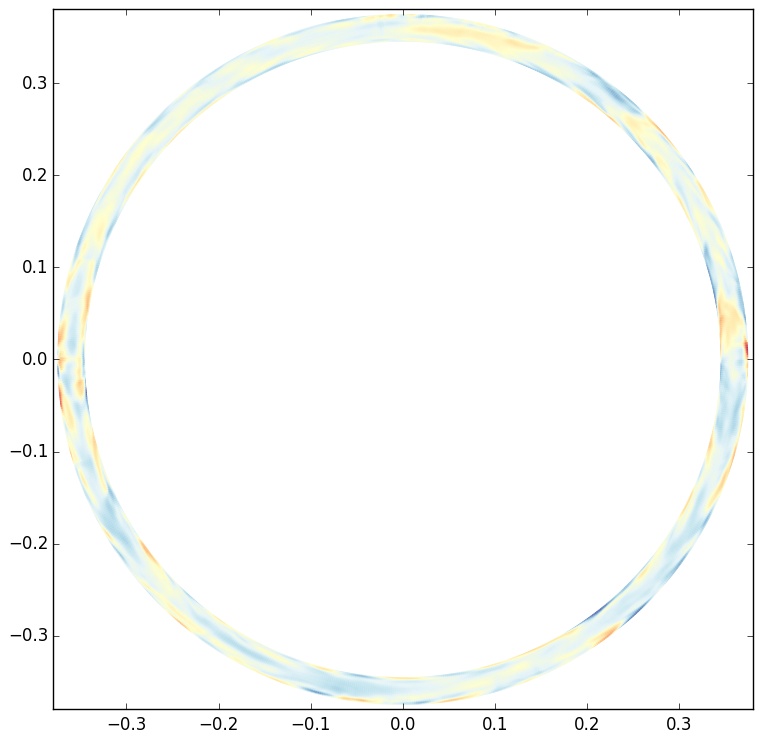

In [31]:
mode = 6
DM2 = D[:,1:end-1]*L[:,mode]
DM2real = real(DM2)
plot_loop_whole_save((DM2real-minimum(DM2real))/(maximum(DM2real)-minimum(DM2real)),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2)).png")